## Why is the tracer on the canyon box wrong?


In [1]:
import gsw 

from math import *

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

%matplotlib inline

from MITgcmutils import rdmds

from netCDF4 import Dataset

import numpy as np

import os 

import pandas as pd

import pylab as pl

import scipy.io

import scipy as spy

import seaborn as sns

import sys

In [2]:
lib_path = os.path.abspath('../../Building_canyon/BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts
#lib_path = os.path.abspath('../BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts

sys.path.append(lib_path)

import ReadOutTools_MITgcm as rout 
import MetricsPythonTools as mpt 

In [3]:
sns.set()
sns.set_style('darkgrid')
sns.set_context('talk')

In [4]:
#Exp
#CGrid = '/Users/Karina/Research/PhD/Tracers/TemporaryData/BARKLEY/run01/gridGlob.nc' # Smallest volume grid, closed bdy, no canyon.
CGrid = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run02/gridGlob.nc' # Smallest volume grid, closed bdy, no canyon.

CState = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run02/stateGlob.nc' # Smallest volume grid, closed bdy, no canyon.

CPtracers = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run02/ptracersGlob.nc' # Smallest volume grid, closed bdy, no canyon.
phiHyd = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run02/phiHydGlob.nc'
pout = Dataset(phiHyd)
CGridOut = Dataset(CGrid)

for dimobj in pout.variables.values():
    print dimobj



<type 'netCDF4.Variable'>
float64 X(X)
    long_name: X-coordinate of cell center
    units: meters
unlimited dimensions: 
current shape = (360,)
filling off

<type 'netCDF4.Variable'>
float64 Y(Y)
    long_name: Y-Coordinate of cell center
    units: meters
unlimited dimensions: 
current shape = (360,)
filling off

<type 'netCDF4.Variable'>
float64 Z(Z)
    long_name: vertical coordinate of cell center
    units: meters
    positive: up
unlimited dimensions: 
current shape = (90,)
filling off

<type 'netCDF4.Variable'>
float64 T(T)
    long_name: model_time
    units: s
unlimited dimensions: T
current shape = (18,)
filling off

<type 'netCDF4.Variable'>
int32 iter(T)
    long_name: iteration_count
unlimited dimensions: T
current shape = (18,)
filling off

<type 'netCDF4.Variable'>
float32 phiHyd(T, Z, Y, X)
unlimited dimensions: T
current shape = (18, 90, 360, 360)
filling off



In [5]:
# General input

nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 
numTr = 3 # number of tracers in run

rc = CGridOut.variables['RC']

xc = rout.getField(CGrid, 'XC') # x coords tracer cells
yc = rout.getField(CGrid, 'YC') # y coords tracer cells

drF = CGridOut.variables['drF'] # vertical distance between faces
drC = CGridOut.variables['drC'] # vertical distance between centers

labels = ['Linear','Salt','Oxygen','Nitrate','Silicate','Phosphate','Nit. Acid','Methane']

Tp = pout.variables['T']
#print(drC[:])
#print(np.shape(drC))

In [6]:
def get_iniProfile(exp, run, TrNum, key):
    '''Get column from the pandas dataframe containing initial profiles using the key name, run (01, 02, etc) and experiment 
    abreviated name (BAR, CNTDIFF, 3DDIFF, NOGMREDI), TrNum (1,2,3, etc). All input variables are strings.
    Returns the desired column from the dataframe.'''
    df = pd.read_csv(('results/metricsDataFrames/%srun%siniTr%s.csv' %(exp,run,TrNum)))
    col = df[key]
    return col

def get_metrics(exp, run, TrNum, key):
    '''Get column from a tracer metrics pandas dataframe using the key name, run (01, 02, etc) and experiment 
    abreviated name (BAR, CNTDIFF, 3DDIFF, NOGMREDI). All input variables are strings. Returns the desired column from the dataframe'''
    df = pd.read_csv(('results/metricsDataFrames/%srun%sTr%s.csv' %(exp,run,TrNum)))
    col = df[key]
    return col


In [27]:
def plot_CSTr(TrMask,yc,rc, zfin,xh1,xh2,tt):
    '''Make plots to see what the tracer along-shelf integrated tracer concentration is.'''
    
    fig46=plt.figure(figsize=(22,12))
    sns.set(context='talk', style='darkgrid', font='sans-serif', font_scale=1.1,rc={"lines.linewidth": 1.5})

    HH =TrMask[:,:zfin,yh1:300,xh1:xh2]
    SS = TrMask[:,:zfin,yin:,:]
    
    HHsum = np.sum(TrMask[tt,:,:,:],axis=2)
    SSsum = np.sum(TrMask[tt,:zfin,yin:,:],axis=2)

    HHsum0 = np.sum(TrMask[0,:,:,:],axis=2)
    SSsum0 = np.sum(TrMask[0,:zfin,yin:,:],axis=2)
    
    vmax1 = np.max(HHsum[:,:]-HHsum0[:,:])
    vmax2 = np.max(SSsum[:,:]-SSsum0[:,:])
    
    plt.subplot(2,3,1)
    plt.pcolor(yc[:,0]/1000,rc[:],HHsum[:,:],cmap='rainbow')
    plt.colorbar()
    plt.ylabel('depth (m)')
    plt.title('Along-shore integrated tr at t=%1.1f days' %(tt/2.0))

    plt.subplot(2,3,4)
    plt.xlabel('Cross-shore distance (km)')
    plt.pcolor(yc[yin:,180]/1000,rc[:zfin],SSsum[:,:],cmap='rainbow')
    plt.colorbar()
    plt.ylabel('depth (m)')

    plt.subplot(2,3,2)
    plt.pcolor(yc[:,0]/1000,rc[:],HHsum[:,:]-HHsum0[:,:],cmap='RdYlBu_r',vmax=vmax1, vmin=-vmax1)
    plt.colorbar()
    plt.ylabel('depth (m)')
    plt.title('Along-shelf integrated $\Delta Tr$ ($Tr-Tr_0$)')


    plt.subplot(2,3,5)
    plt.pcolor(yc[yin:,180]/1000,rc[:zfin],SSsum[:,:]-SSsum0[:,:],cmap='RdYlBu_r',vmax = vmax2,vmin=-vmax2)
    plt.colorbar()
    plt.ylabel('depth (m)')
    plt.xlabel('Cross-shore distance (km)')

    plt.subplot(2,3,3)
    plt.title('Along-shelf and depth integrated $\Delta Tr$ ($Tr-Tr_0$)')
    plt.plot(yc[:,0]/1000,np.sum(HHsum[:,:]-HHsum0[:,:],axis=0),label='sum')
    plt.plot(yc[:,0]/1000,np.max(HHsum[:,:]-HHsum0[:,:],axis=0),label='max')
    
    plt.ylabel('$\Delta$ Tracer concentration ')

    plt.subplot(2,3,6)
    plt.plot(yc[yin:,180]/1000,np.sum(SSsum[:,:]-SSsum0[:,:],axis=0), label='sum')
    plt.plot(yc[yin:,180]/1000,np.max(SSsum[:,:]-SSsum0[:,:],axis=0), label='sum')
    plt.xlabel('Cross-shore distance (km)')
    plt.ylabel('$\Delta$ Tracer concentration ')
    
    return(yc[:,0],np.max(HHsum[:,:]-HHsum0[:,:],axis=0))


In [58]:
def FindMaxfont(DeltaTrMask):
    '''Make plots to see what the tracer along-shelf integrated tracer concentration is.'''
    
    HH = DeltaTrMask[:,:,:,180]
    
    HHsum = np.sum(HH,axis=1)
    
    maxFront = np.max(HHsum[:,:],axis=1)
    
    maxInd = np.argmax(HHsum[:,:], axis=1)
    
    return(maxFront, maxInd)


In [8]:
Tr1 = rout.getField(CPtracers, 'Tr01')
Tr4 = rout.getField(CPtracers,'Tr04')
Tr8 = rout.getField(CPtracers,'Tr08')


In [9]:
Temp = rout.getField(CState,'Temp')
S = rout.getField(CState,'S')
P = rout.getField(phiHyd,'phiHyd')

In [10]:
RhoRef = np.squeeze(rdmds('/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run02/RhoRef'))
#print(RhoRef) # it is constant 999.79998779

/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run02/RhoRef.meta


In [11]:
depth = rout.getField(CGrid, 'Depth')
hFacC = rout.getField(CGrid, 'HFacC')
MaskC = rout.getMask(CGrid, 'HFacC')
nzlim = 30
rA = rout.getField(CGrid, 'rA')
yin = 227
zfin = 30
xi = 180
yi = 50
xh1=120
xh2=240
yh1=227
yh2=267
g = 9.81 # ms^-2

maskExp = mpt.maskExpand(MaskC,Tr1)

Tr1Mask=np.ma.array(Tr1,mask=maskExp)   
Tr4Mask=np.ma.array(Tr4,mask=maskExp)   
Tr8Mask=np.ma.array(Tr8,mask=maskExp)   

TempMask=np.ma.array(Temp,mask=maskExp)   
SMask=np.ma.array(S,mask=maskExp)   
  


In [12]:
# Calculate density and N

alpha = 1.7E-4/237 # 1/degC
beta = 7.6E-4

#Linear eq. of state 
rho = RhoRef*(np.ones(np.shape(RhoRef)) - alpha*(TempMask[0,:,50,180]) + beta*(SMask[0,:,50,180]))

# N^2
N2 = (-g/RhoRef[0])*(rho[2:] - rho[:-2])/(-drC[2:-1]-drC[1:-2]) 
N = np.sqrt(N2)

# Get rid of the two spikes that appear when grid spacing changes

MaskedN = np.ma.masked_greater(N, 0.0037) 
MaskN = MaskedN.mask
rcMasked = np.ma.MaskedArray(rc[1:-1],mask=MaskN)



(0.003541573549378839, 1.4295034916765454e-07)


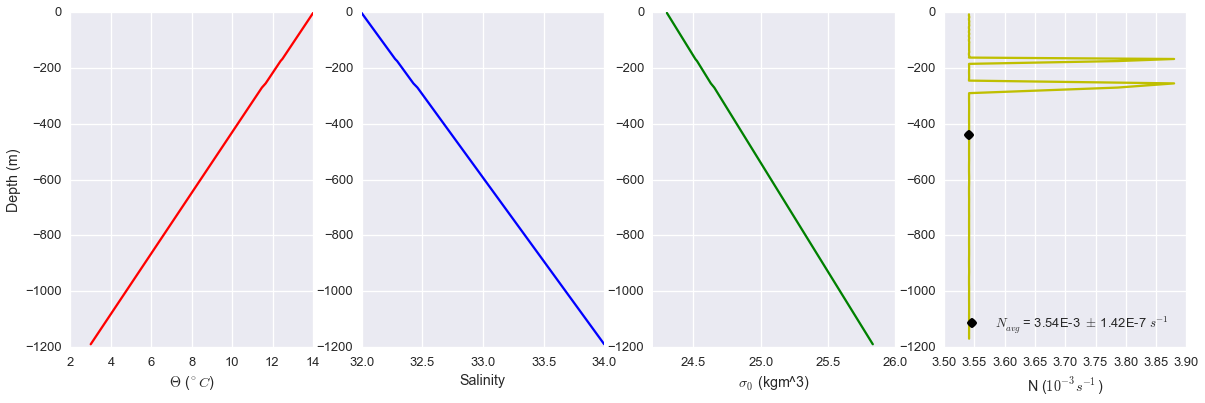

In [13]:
fig1 = plt.figure(figsize=(20,6))

plt.subplot(1,4,1)
plt.plot(TempMask[0,:,50,180],rc[:],'r')
plt.ylabel('Depth (m)')
plt.xlabel('$\Theta$ ($^{\circ}C$)')

plt.subplot(1,4,2)
plt.plot(SMask[0,:,50,180],rc[:],'b')
plt.xlabel('Salinity')

plt.subplot(1,4,3)
plt.plot(rho-RhoRef,rc[:],'g')
plt.xlabel('$\sigma_0$ (kgm^3)')

plt.subplot(1,4,4)
plt.plot(N*1000,rc[1:-1],'y')
plt.plot(np.mean(MaskedN)*1000,np.mean(rcMasked),'ko',label = '$N_{avg}$ = 3.54E-3 $\pm$ 1.42E-7 $s^{-1}$ ')
plt.legend(loc=8)
plt.xlabel('N ($10^{-3}s^{-1}$)')

print(np.mean(MaskedN), np.std(MaskedN))

## Linear profile

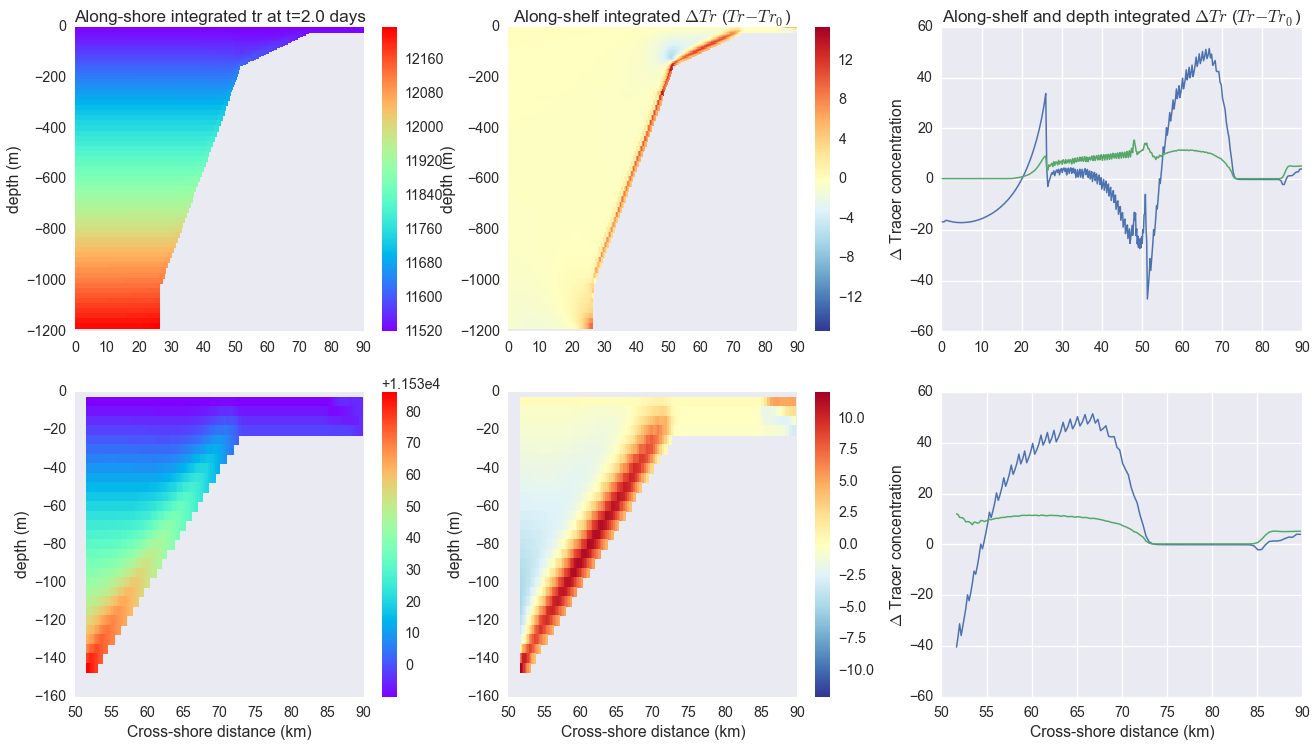

In [14]:
plot_CSTr(Tr1Mask,yc,rc, zfin,xh1,xh2,4)

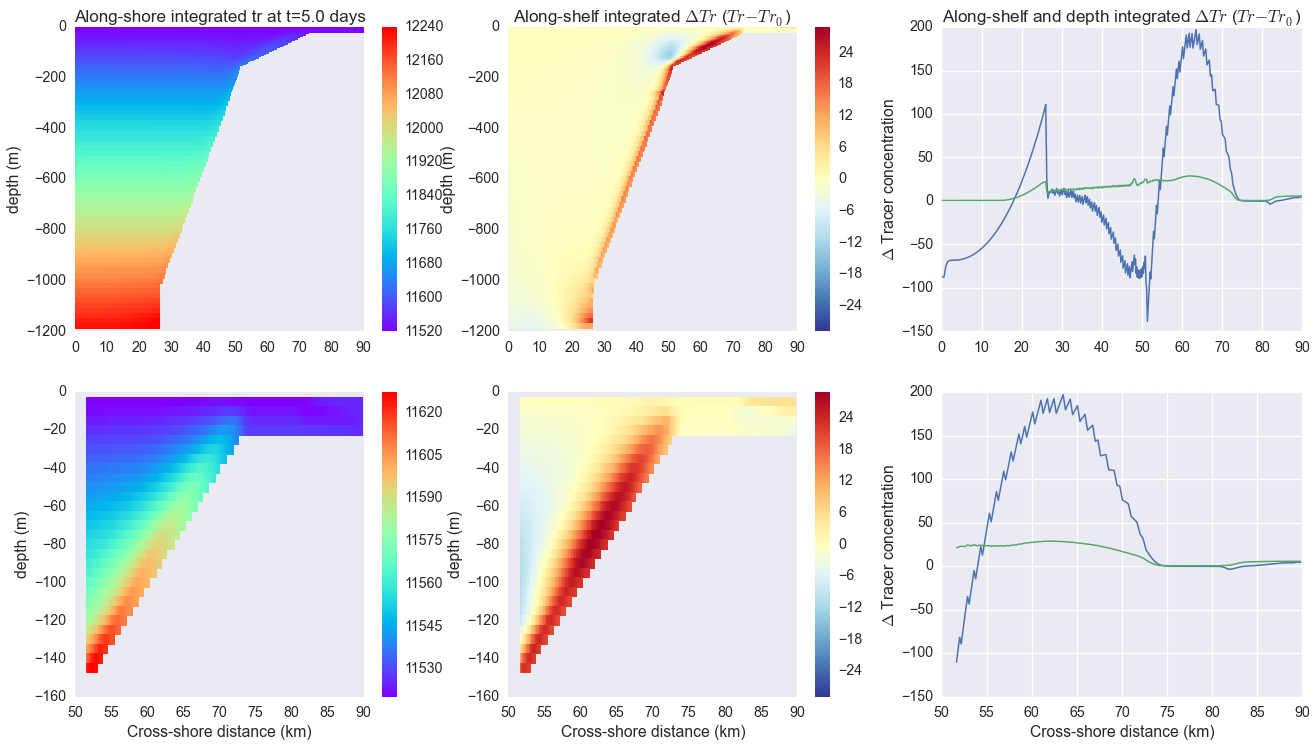

In [15]:
plot_CSTr(Tr1Mask,yc,rc, zfin,xh1,xh2,10)

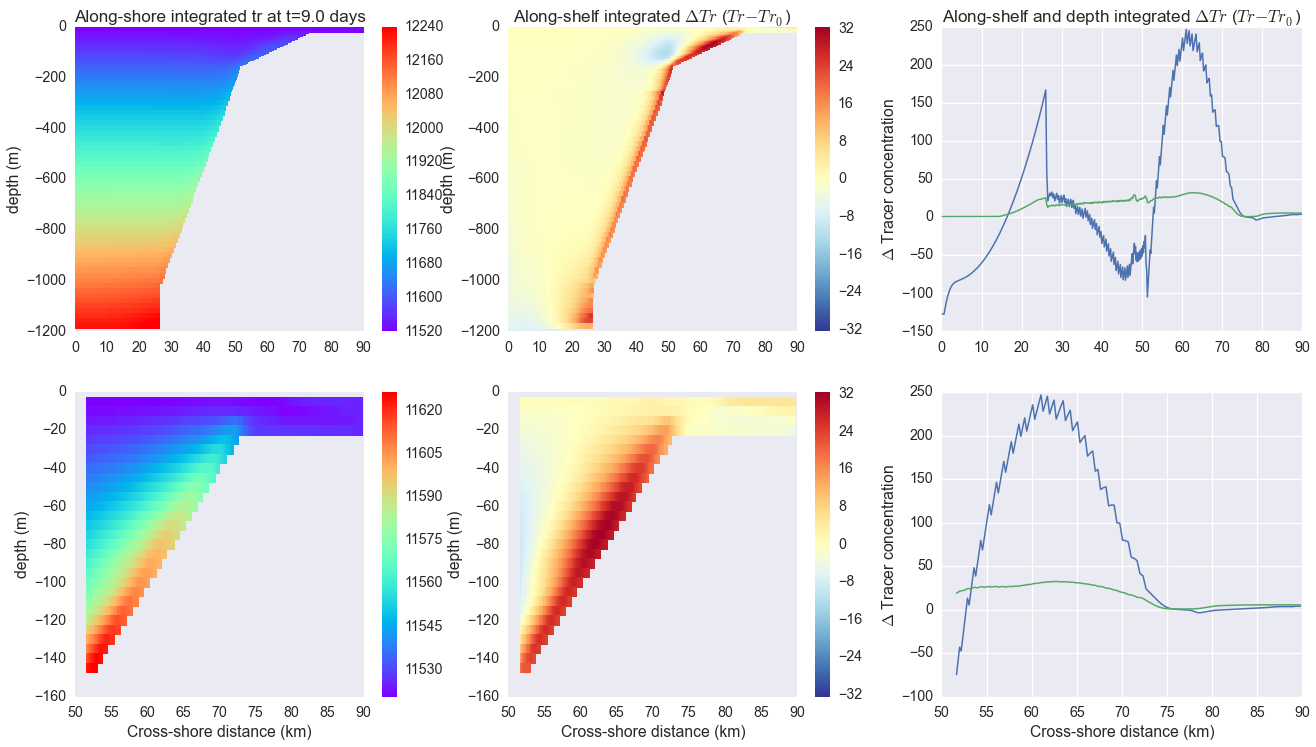

In [16]:
plot_CSTr(Tr1Mask,yc,rc, zfin,xh1,xh2,18)

## Nitrate - like profile

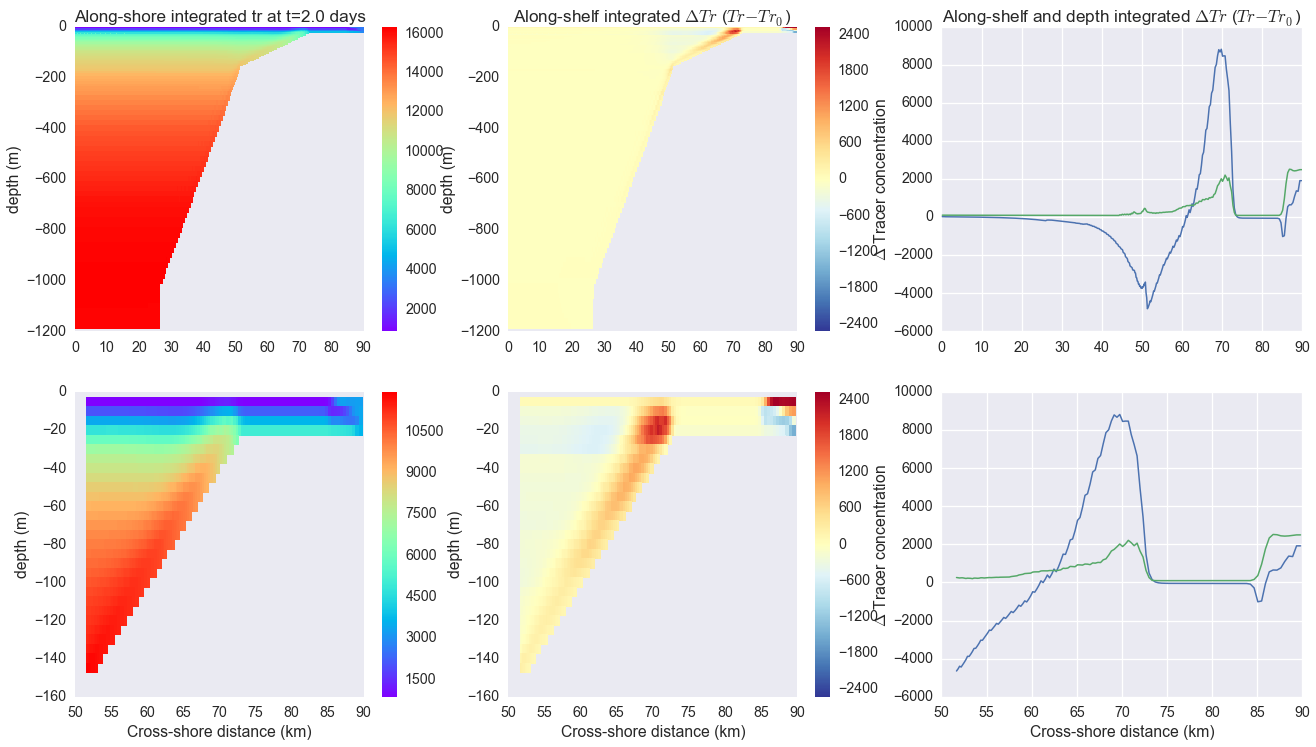

In [17]:
plot_CSTr(Tr4Mask,yc,rc, zfin,xh1,xh2,4)

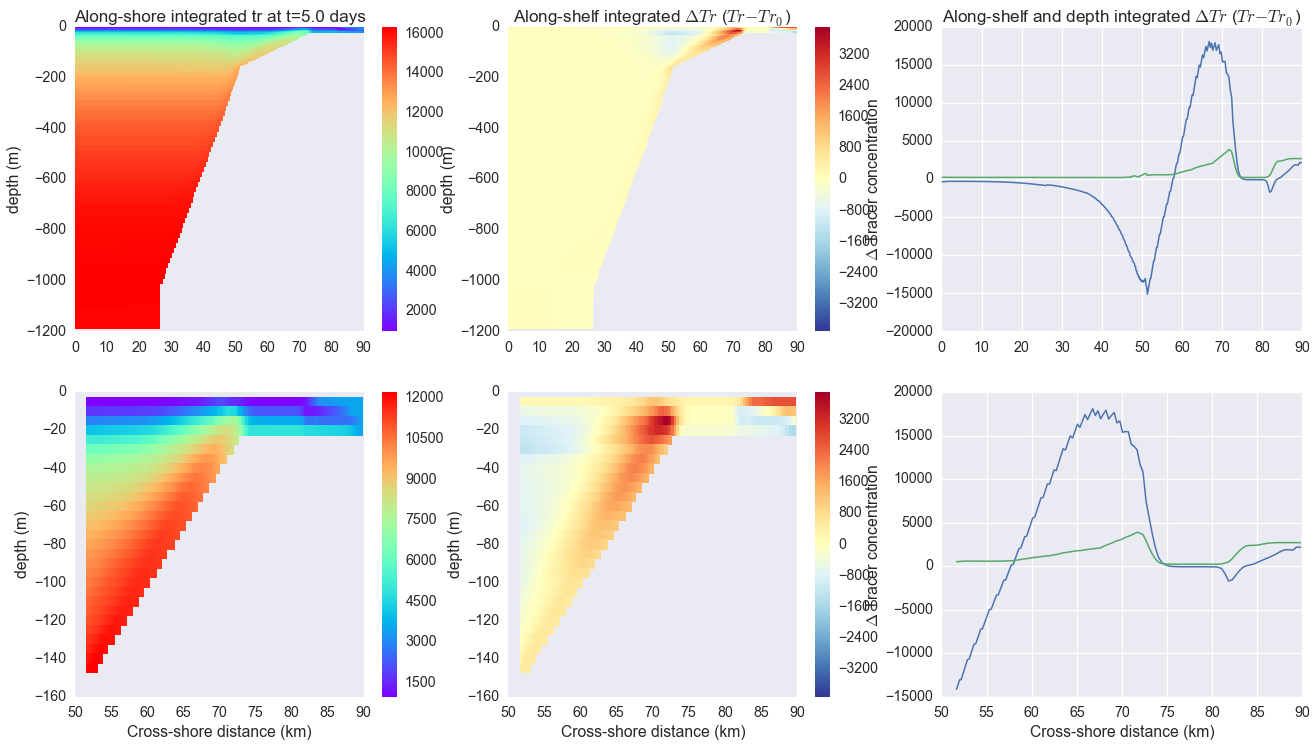

In [18]:
plot_CSTr(Tr4Mask,yc,rc, zfin,xh1,xh2,10)

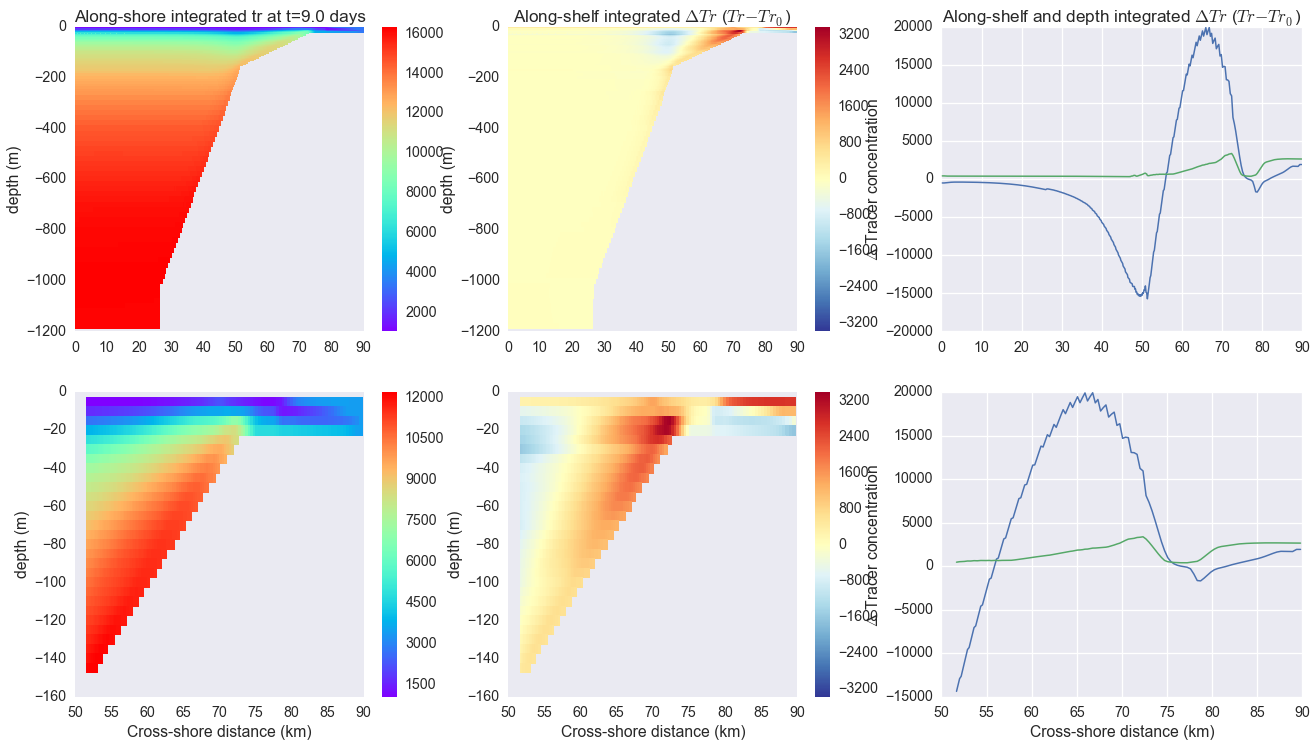

In [19]:
plot_CSTr(Tr4Mask,yc,rc, zfin,xh1,xh2,18)

## Methane-like profile


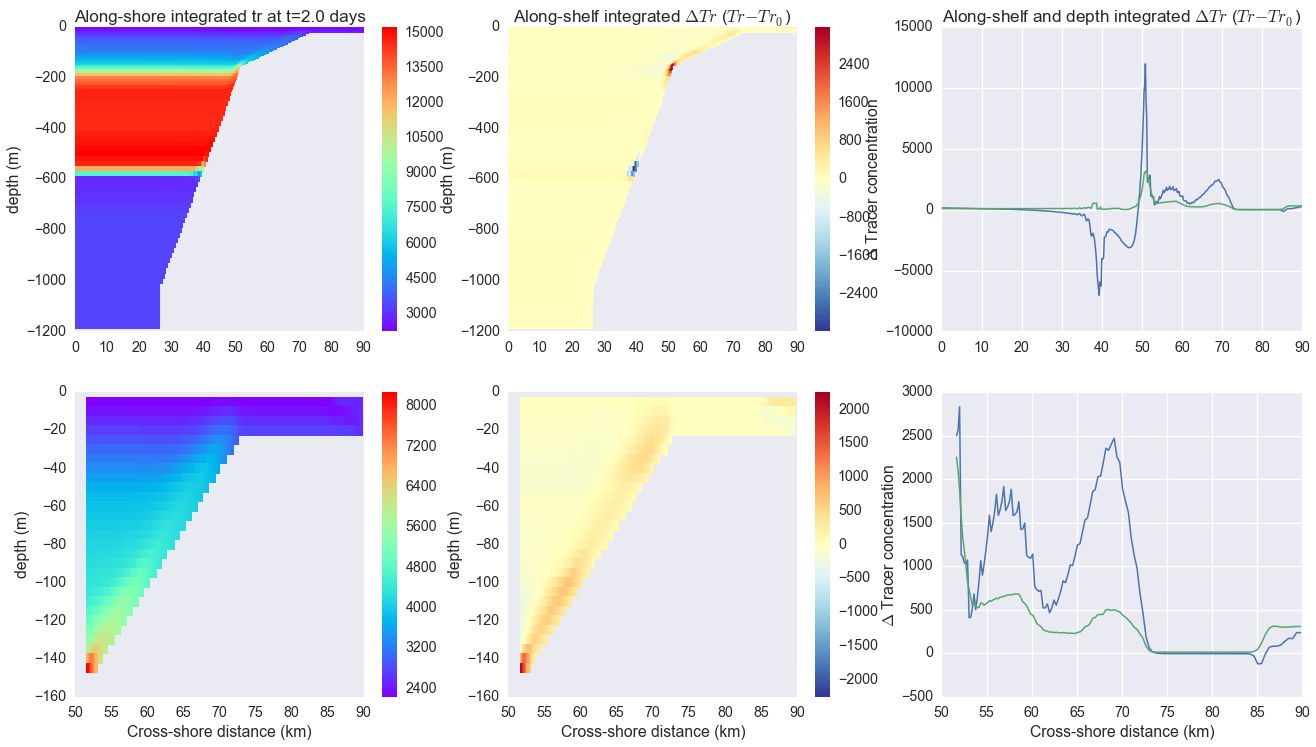

In [20]:
plot_CSTr(Tr8Mask,yc,rc, zfin,xh1,xh2,4)

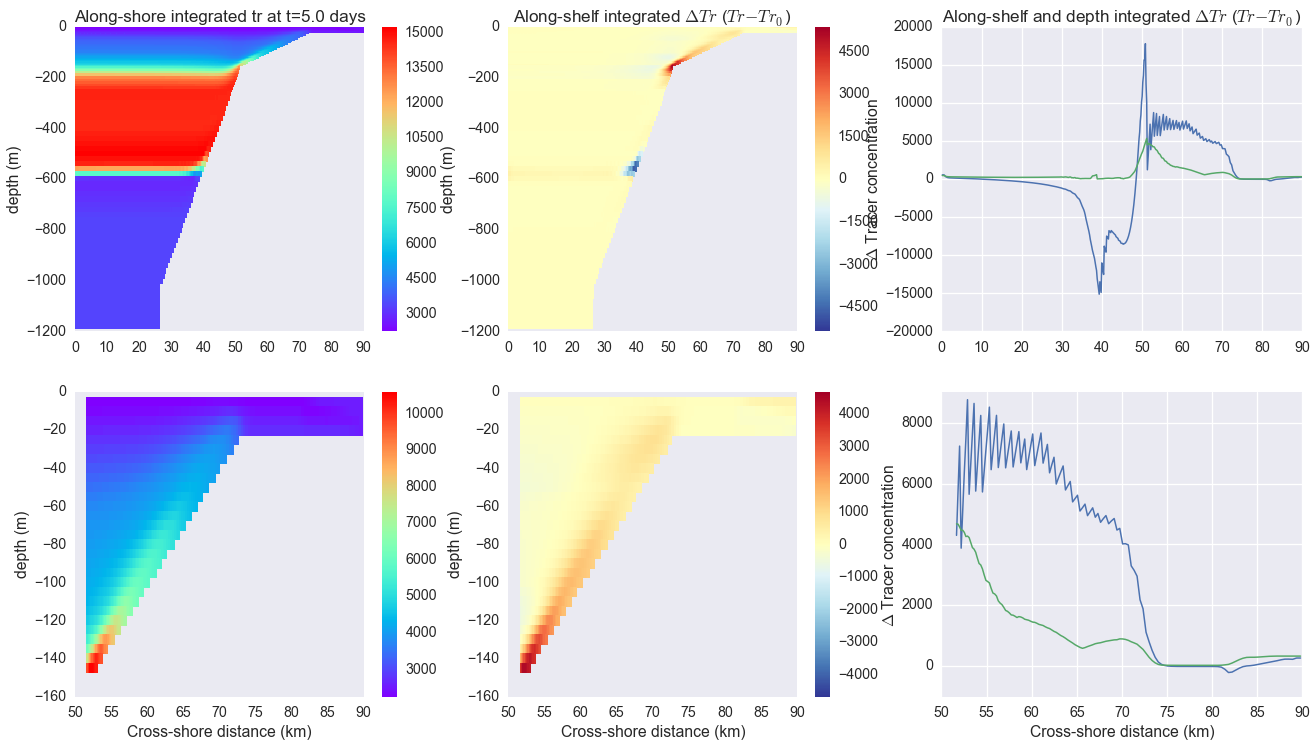

In [21]:
plot_CSTr(Tr8Mask,yc,rc, zfin,xh1,xh2,10)

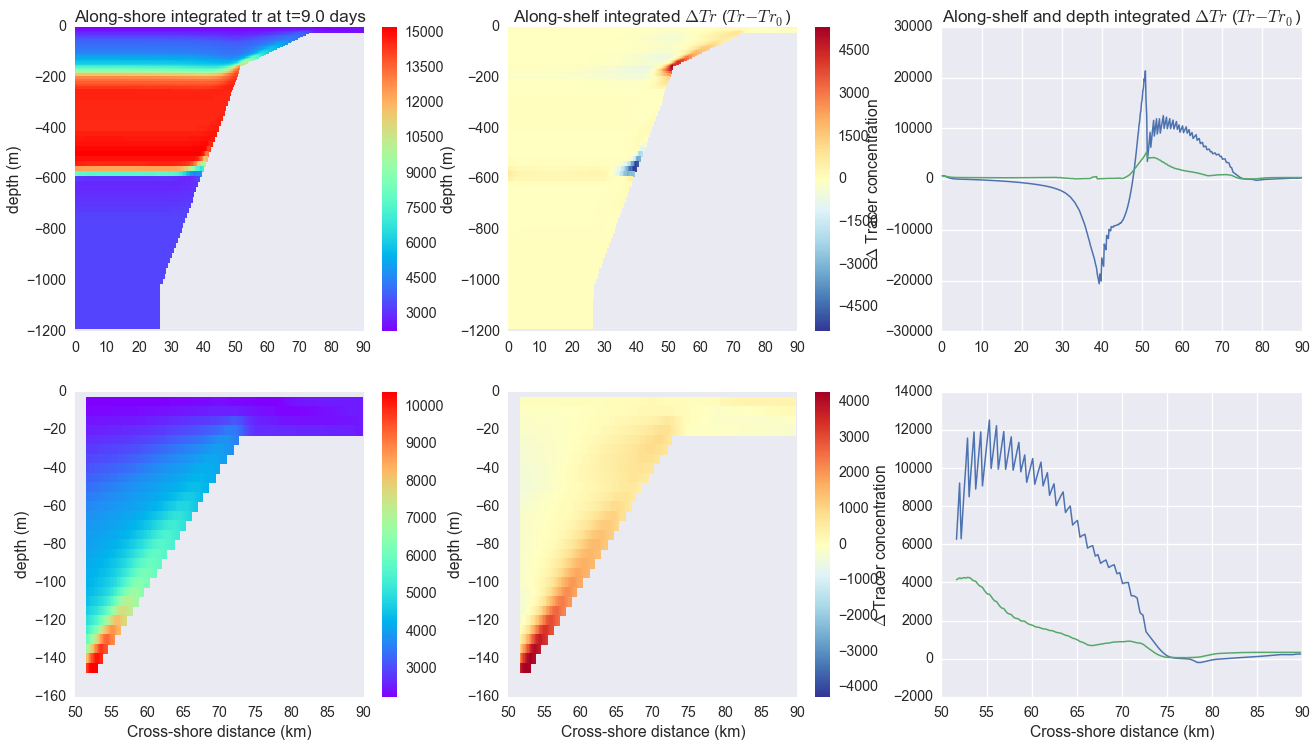

In [22]:
plot_CSTr(Tr8Mask,yc,rc, zfin,xh1,xh2,18)

## Phosphate - like tracer

In [23]:
Tr6 = rout.getField(CPtracers,'Tr06')
Tr6Mask=np.ma.array(Tr6,mask=maskExp) 


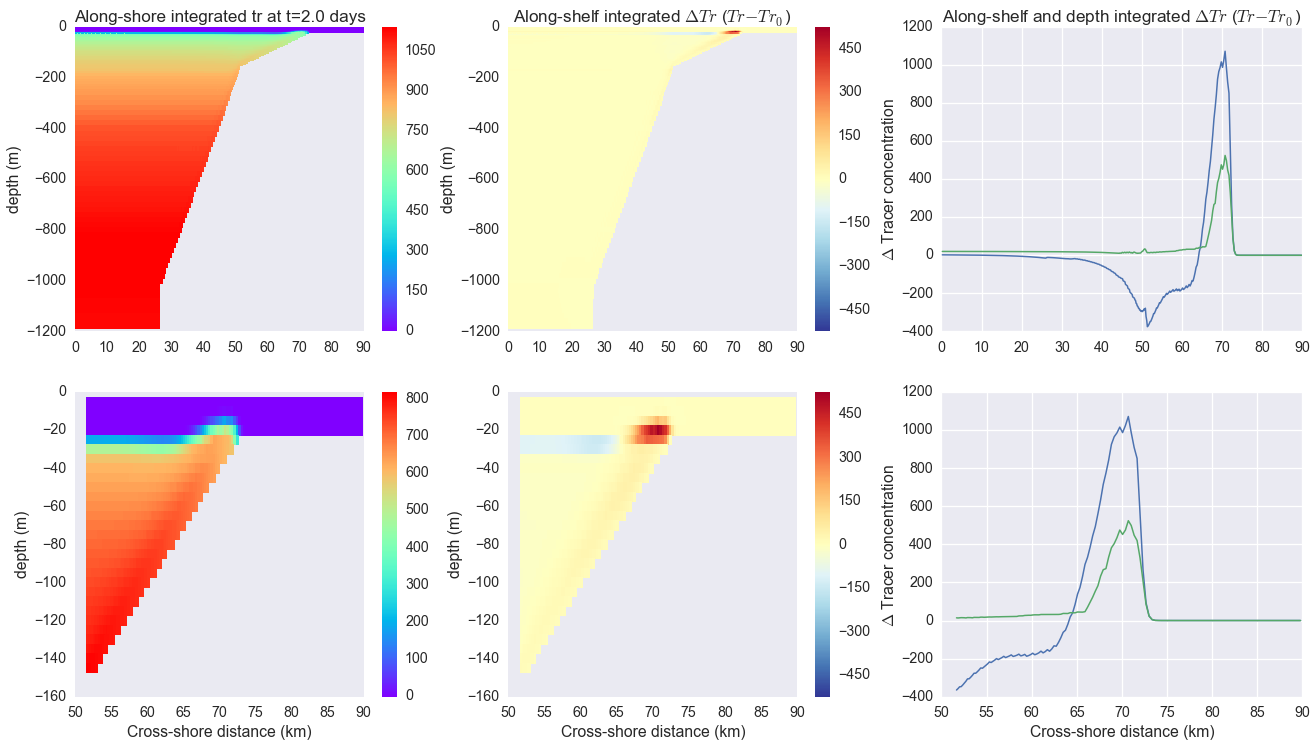

In [24]:
plot_CSTr(Tr6Mask,yc,rc, zfin,xh1,xh2,4)

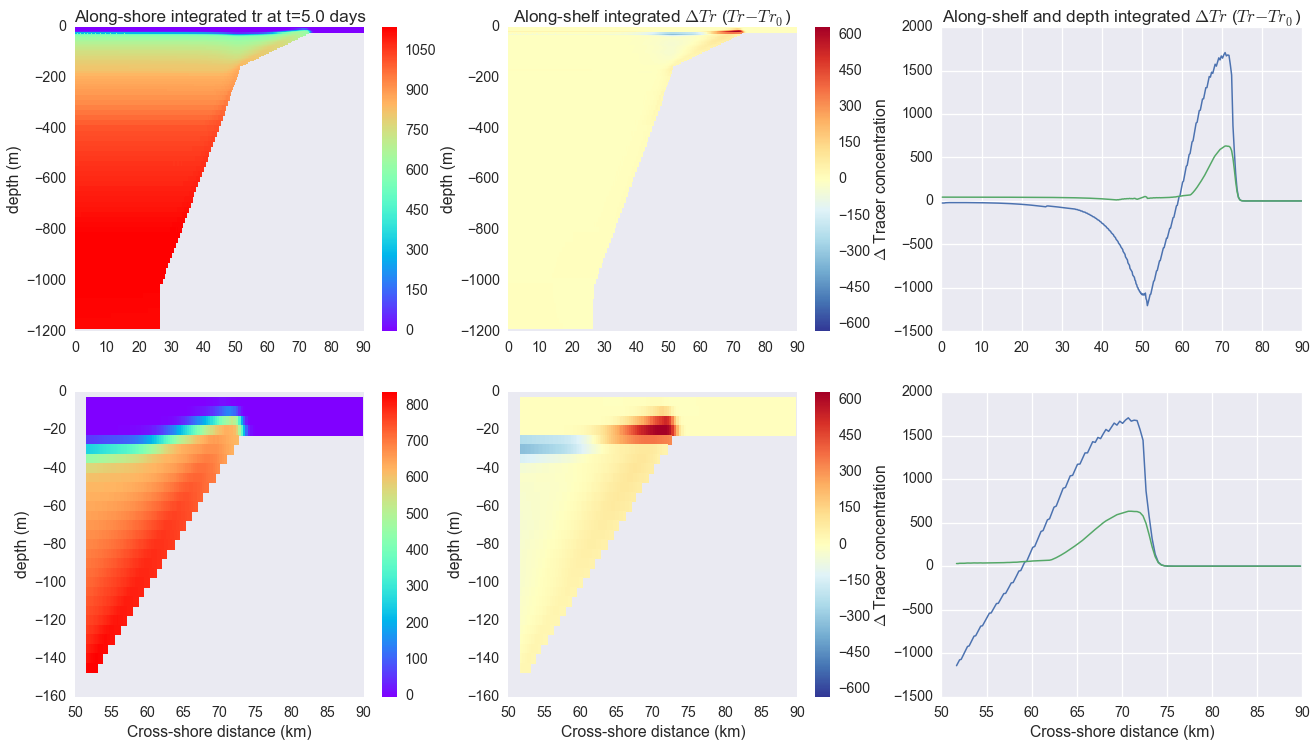

In [25]:
plot_CSTr(Tr6Mask,yc,rc, zfin,xh1,xh2,10)

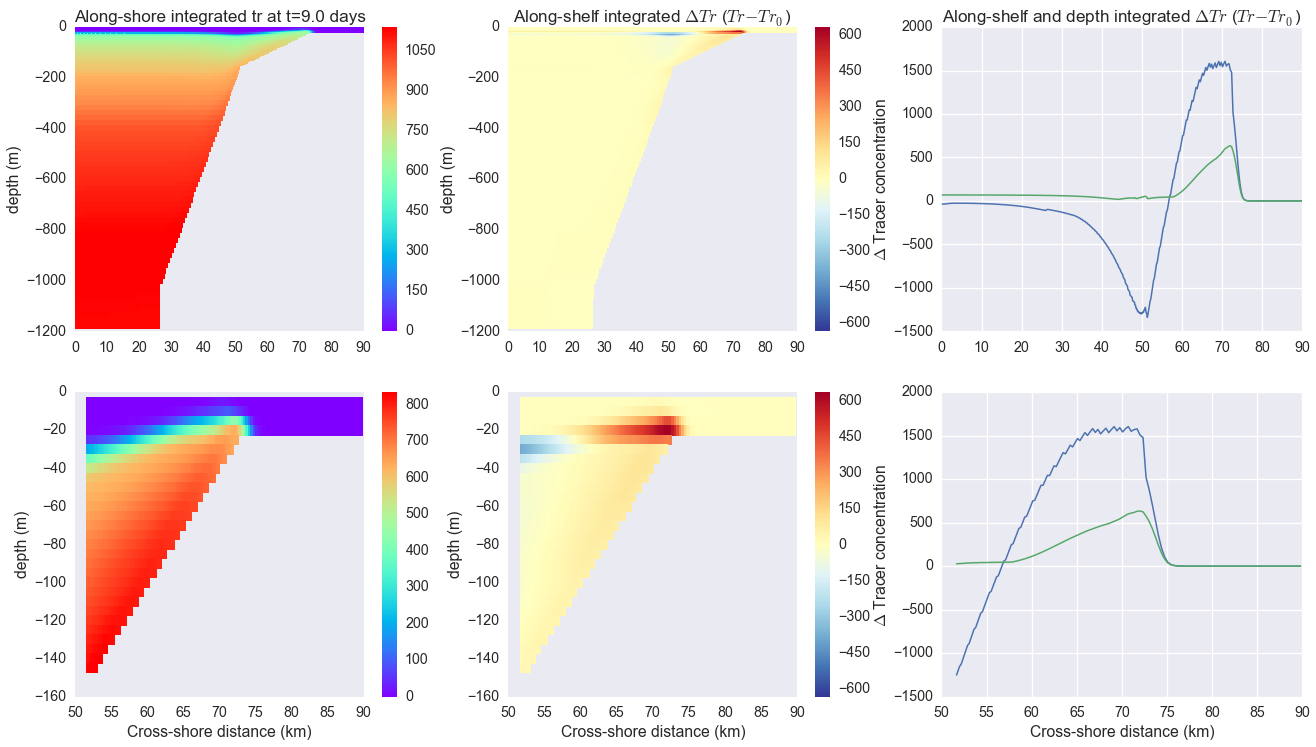

In [26]:
plot_CSTr(Tr6Mask,yc,rc, zfin,xh1,xh2,18)

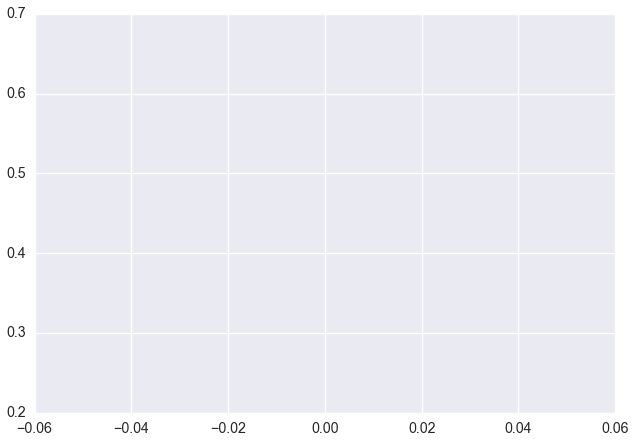

In [61]:
times = np.arange(0,9,0.5)

#Tr1exp = mpt.maskExpand(Tr1Mask[0,:,:,:],Tr1Mask) # this is not a mask but the same functions works to expand the dims
#Tr1exp = Tr1Mask - Tr1exp

#Tr4exp = mpt.maskExpand(Tr4Mask[0,:,:,:],Tr4Mask) # this is not a mask but the same functions works to expand the dims
#Tr4exp = Tr4Mask - Tr4exp

#Tr8exp = mpt.maskExpand(Tr8Mask[0,:,:,:],Tr8Mask) # this is not a mask but the same functions works to expand the dims
#Tr8exp = Tr8Mask - Tr8exp


tracerList = [Tr1exp,Tr4exp,Tr8exp]

for tracer in tracerList:
    
    [maxFront, maxInd] = FindMaxfont(tracer)
    
    maxIndperT = np.argmax(maxInd)
    
    #maxpertime = maxInd[maxIndperT]
    
    plt.plot(yc[maxIndperT,180]/1000)
    

In [62]:
print(maxInd)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
